<a href="https://colab.research.google.com/github/misbahsy/APMonitor-do/blob/master/EstimatorTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dynamic Estimation Tuning

<p class='vspace'>Dynamic estimation tuning is the process of adjusting certain objective function terms to give more desirable solutions. As an example, a dynamic estimation application such as moving horizon estimation (MHE) may either track noisy data too closely or the updates may be too slow to catch unmeasured disturbances of interest. Tuning is the process of achieving acceptable estimator performance based on unique aspects of the application.
</p>
<div class='vspace'></div>
##<h2>Common Tuning Parameters for MHE</h2>
<p>Tuning typically involves adjustment of objective function terms or constraints that limit the rate of change (DMAX), penalize the rate of change (DCOST), or set absolute bounds (LOWER and UPPER). Measurement availability is indicated by the parameter (FSTATUS). The optimizer can also include (1=on) or exclude (0=off) a certain adjustable parameter (FV) or manipulated variable (MV) with STATUS. Another important tuning consideration is the time horizon length. Including more points in the time horizon allows the estimator to reconcile the model to more data but also increases computational time.
</p>
<div class='vspace'></div><div><img src='http://apmonitor.com/do/uploads/Main/download.png' alt='' title='' /> <a class='urllink' href='http://apmonitor.com/do/uploads/Main/mhe_tuning_widget.zip' rel='nofollow'>MHE Tuning IPython Widget</a></div>
<div class='vspace'></div><div><img width='550px' src='http://apmonitor.com/do/uploads/Main/mhe_tuning_widget.png' alt='' title='' /></div>
<p class='vspace'>Below are common application, FV, MV, and CV tuning constants that are adjusted to achieve desired model predictive control performance. 
</p>
<div class='vspace'></div><ul><li>Application tuning
<ul><li>DIAGLEVEL = diagnostic level (0-10) for solution information
</li><li>EV_TYPE = 1 for l<sub>1</sub>-norm and 2 for squared error objective
</li><li>IMODE = 5 or 8 for moving horizon estimation
</li><li>MAX_ITER = maximum iterations
</li><li>MAX_TIME = maximum time before stopping
</li><li>MV_TYPE = Set default MV type with 0=zero-order hold, 1=linear interpolation
</li><li>SOLVER
<ul><li>0=Try all available solvers
</li><li>1=APOPT (MINLP, Active Set SQP)
</li><li>2=BPOPT (NLP, Interior Point, SQP)
</li><li>3=IPOPT (NLP, Interior Point, SQP) 
</li></ul></li></ul><div class='vspace'></div></li><li>Fixed Value (FV) - single parameter value over time horizon
<ul><li>DMAX = maximum that FV can move each cycle
</li><li>LOWER = lower FV bound
</li><li>FSTATUS = feedback status with 1=measured, 0=off 
</li><li>STATUS = turn on (1) or off (0) FV
</li><li>UPPER = upper FV bound
</li></ul><div class='vspace'></div></li><li>Manipulated Variable (MV) - parameter can change over time horizon
<ul><li>COST = (+) minimize MV, (-) maximize MV
</li><li>DCOST = penalty for MV movement
</li><li>DMAX = maximum that MV can move each cycle
</li><li>FSTATUS = feedback status with 1=measured, 0=off 
</li><li>LOWER = lower MV bound
</li><li>MV_TYPE = MV type with 0=zero-order hold, 1=linear interpolation
</li><li>STATUS = turn on (1) or off (0) MV
</li><li>UPPER = upper MV bound
</li></ul><div class='vspace'></div></li><li>Controlled Variable (CV) tuning
<ul><li>COST = (+) minimize MV, (-) maximize MV
</li><li>FSTATUS = feedback status with 1=measured, 0=off 
</li><li>MEAS_GAP = measurement gap for estimator dead-band 
</li></ul></li></ul><p class='vspace'>There are several ways to change the tuning values. Tuning values can either be specified before an application is initialized or while an application is running. To change a tuning value before the application is loaded, use the <em>apm_option()</em> function such as the following example to change the lower bound in MATLAB or Python for the FV named <em>p</em>.
</p>
<div class='vspace'></div><pre> apm_option(server,app,'p.LOWER',0)
</pre><p class='vspace'>The upper and lower measurement deadband for a CV named <em>y</em> are set to values around the measurement. In this case, an acceptable range for the model prediction is to intersect the measurement of 10.0 between 9.5 and 10.5 with a MEAS_GAP of 1.0 (or +/-0.5).
</p>
<div class='vspace'></div><pre> apm_option(server,app,'y.MEAS_GAP',1.0)
</pre><p class='vspace'>Application constants are modified by indicating that the constant belongs to the group <em>apm</em>. IMODE is adjusted to either solve the MHE problem with a simultaneous (5) or sequential (8) method. In the case below, the application IMODE is changed to simultaneous mode.
</p>
<div class='vspace'></div><pre> apm_option(server,app,'apm.IMODE',5)
</pre>

In [3]:
#@title ##MHE Tuning Widget

# run once to install gekko
try:
    from pip import main as pipmain
except:
    from pip._internal import main as pipmain
pipmain(['install','gekko'])

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import ipywidgets as wg
from IPython.display import display
from gekko import GEKKO


# data
ud = np.array([0,0.1,0.1,0.1,1,1,1,1,1,1,1,1,1,1,1])
yd = np.array([0,0.1,-0.1,0.05,0.2,0.4,0.55, \
               0.65,0.7,0.74,0.77,0.79,0.81, \
               0.8,0.79])

# initialize MHE
# MHE Model
m = GEKKO(remote=False)

m.time = np.linspace(0,14,15)

#Parameters
u = m.MV() #input
K = m.MV(value=0.85, lb=0.5, ub=1.5) #gain
tau = m.FV(value=2.5, lb=1, ub=10) #time constant

#Variables
y = m.CV() #measurement

#Equations
m.Equation(tau * y.dt() == -y + K*u)

#Options
m.options.IMODE = 5 #MHE
m.options.EV_TYPE = 1
m.options.TIME_SHIFT = 0
m.options.SOLVER = 1

# STATUS = 0, optimizer doesn't adjust value
# STATUS = 1, optimizer can adjust
u.STATUS = 0
K.STATUS = 1
tau.STATUS = 0
y.STATUS = 1

# FSTATUS = 0, no measurement
# FSTATUS = 1, measurement used to update model
u.FSTATUS = 1
K.FSTATUS = 0
tau.FSTATUS = 0
y.FSTATUS = 1
y.WMODEL = 0.0 # no weight to prior model predictions
y.WMEAS = 10.0 # weight for matching to measurements
#y.MEAS = 0.79 # last measurement in horizon

# DMAX = maximum movement each cycle
K.DMAX = 1
tau.DMAX = .1

# MEAS_GAP = dead-band for measurement / model mismatch
y.MEAS_GAP = 0.2

# Insert measurements
u.value = ud
y.value = yd

# optimize parameters
m.solve(disp=False)

#### Manipulated Variable (MV) Tuning - Gain (K)

* COST = (+) minimize MV, (-) maximize MV 
* DCOST = penalty for MV movement 
* DMAX = maximum that MV can move each cycle 
* MV_STEP_HOR = default 1, higher integers allow MV to move less frequently

#### Controlled Variable (CV) Tuning - Measured Output (y)

* MEAS_GAP = no penalty dead-band around measurements
* WMEAS = measurement weight in objective function
* WMODEL = prior model prediction weight in objective function

In [5]:
def mhe_tuning(cost,dcost,dmax,mv_step,meas_gap):
    K.COST = cost
    K.DCOST = dcost
    K.DMAX = dmax
    K.MV_STEP_HOR = mv_step
    y.MEAS_GAP = meas_gap
    y.value = yd
    
    # solve MHE
    m.solve(disp=False)
        
    plt.figure(1,figsize=(10,7))
    ax=plt.subplot(2,1,1)
    ax.grid()
    plt.plot(m.time,u,'b-',label=r'$Input (u)$')
    plt.plot(m.time,K,'r-o',label=r'$Gain (K)$')
    plt.legend(loc='best')
    plt.ylabel('MV')

    ax=plt.subplot(2,1,2)
    ax.grid()
    plt.plot(m.time,y,'r:',linewidth=2,label=r'$y_{pred}$')
    plt.plot(m.time,yd+meas_gap/2.0,'k--',linewidth=2,label=r'$y_{db-hi}$')
    plt.plot(m.time,yd,'kx',linewidth=2,label=r'$y_{meas}$')
    plt.plot(m.time,yd-meas_gap/2.0,'k--',linewidth=2,label=r'$y_{db-lo}$')
    plt.legend(loc='best')
    plt.ylabel('CV')
    plt.xlabel('Time (sec)')
    plt.savefig('test.png')

    
cost_slide = wg.FloatSlider(value=0.0,min=-1.0,max=1.0,step=0.1)
dcost_slide = wg.FloatSlider(value=0.1,min=0.0,max=1.0,step=0.1)
dmax_slide = wg.FloatSlider(value=1.0,min=0.0,max=1.0,step=0.1)
mv_step_slide = wg.FloatSlider(value=1,min=1,max=10,step=1)
meas_gap_slide = wg.FloatSlider(value=0.2,min=0.0,max=1.0,step=0.1)
wg.interact(mhe_tuning, cost=cost_slide, \
            dcost=dcost_slide, dmax=dmax_slide, \
            mv_step=mv_step_slide, meas_gap=meas_gap_slide)

interactive(children=(FloatSlider(value=0.0, description='cost', max=1.0, min=-1.0), FloatSlider(value=0.1, de…

<function __main__.mhe_tuning>

##Exercise
<p><strong>Objective:</strong> Design an estimator to predict an unknown parameters so that a simple model is able to predict the response of a more complex process. Tune the estimator to achieve either tracking or predictive performance. <em>Estimated time: 1 hour.</em>
</p>
<div class='vspace'></div><div><img src='http://apmonitor.com/do/uploads/Main/download.png' alt='' title='' /> <a class='urllink' href='http://apmonitor.com/do/uploads/Main/estimator_tuning_source.zip' rel='nofollow'>Estimator Tuning Source Files</a></div>

</div>
<p class='vspace'>Design an estimator to predict <em>K</em> and <em>tau</em> of a 1st order model to predict the dynamic response of a 1st order, 2nd order, and 10th order process. For the 2nd and 10th order systems, there is process/model mismatch. This means that the structure of the model can never exactly match the actual process because the equations are inherently incorrect. The parameter values are adjusted to best approximate the process even though the model is deficient. The process order is adjusted in the file <em>process.apm</em> file in the <em>Constants</em> section.
</p>
<div class='vspace'></div><pre> Constants
   ! process model order
   n = 1  ! change to 1, 2, and 10
</pre><p class='vspace'>In each case, tune the estimator to favor either acceptable tracking or predictive performance. Tracking performance is the ability of the estimator to synchronize with measurements and is demonstrated with overall agreement between the model predictions and the measurements. Predictive performance sacrifices tracking performance to achieve more consistent values that are valid over a longer predictive horizon for model predictive control.
</p>

In [8]:
#@title ###Solution
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/yw_a9ektOqc?rel=0" frameborder="0" allowfullscreen></iframe>


 ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            5
   Intermediates:            1
   Connections  :            0
   Equations    :            3
   Residuals    :            2
 
 Number of state variables:              3
 Number of total equations: -            3
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 solver            3  not supported
 using default solver: APOPT
 ----------------------------------------------
 Dynamic Simulation with APOPT Solver
 ----------------------------------------------
    1  0.00000E+00  0.00000E+00
 Successful solution
 
 ---------------------------------------------------
 So

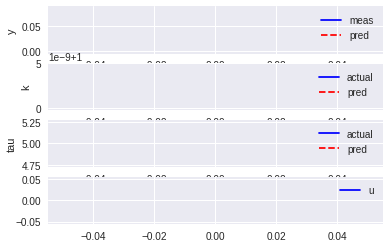

 ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            5
   Intermediates:            1
   Connections  :            0
   Equations    :            3
   Residuals    :            2
 
 Number of state variables:              3
 Number of total equations: -            3
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 solver            3  not supported
 using default solver: APOPT
 ----------------------------------------------
 Dynamic Simulation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  0.00000E+00  8.84249E-01
    1  0.00000E+00  8.84249E-01
 Successful s

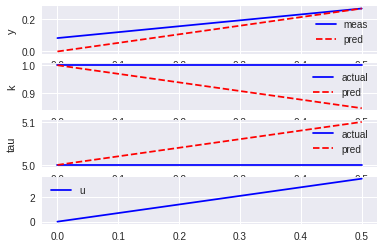

 ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            5
   Intermediates:            1
   Connections  :            0
   Equations    :            3
   Residuals    :            2
 
 Number of state variables:              3
 Number of total equations: -            3
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 solver            3  not supported
 using default solver: APOPT
 ----------------------------------------------
 Dynamic Simulation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  4.99600E-36  3.21545E-01
    1  4.99600E-36  3.21545E-01
 Successful s

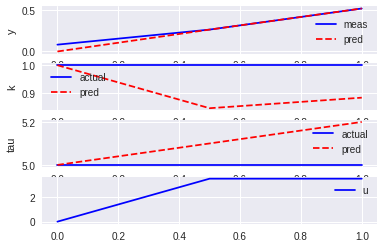

 ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            5
   Intermediates:            1
   Connections  :            0
   Equations    :            3
   Residuals    :            2
 
 Number of state variables:              3
 Number of total equations: -            3
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 solver            3  not supported
 using default solver: APOPT
 ----------------------------------------------
 Dynamic Simulation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  1.11022E-36  2.92314E-01
    1  1.11022E-36  2.92314E-01
 Successful s

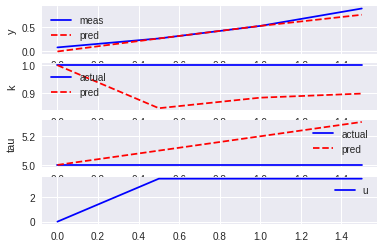

 ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            5
   Intermediates:            1
   Connections  :            0
   Equations    :            3
   Residuals    :            2
 
 Number of state variables:              3
 Number of total equations: -            3
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 solver            3  not supported
 using default solver: APOPT
 ----------------------------------------------
 Dynamic Simulation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  5.55112E-36  2.65740E-01
    1  5.55112E-36  2.65740E-01
 Successful s

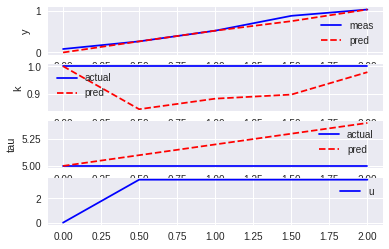

 ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            5
   Intermediates:            1
   Connections  :            0
   Equations    :            3
   Residuals    :            2
 
 Number of state variables:              3
 Number of total equations: -            3
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 solver            3  not supported
 using default solver: APOPT
 ----------------------------------------------
 Dynamic Simulation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  0.00000E+00  2.41582E-01
    1  0.00000E+00  2.41582E-01
 Successful s

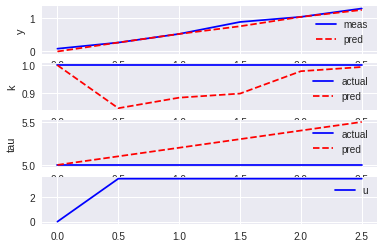

 ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            5
   Intermediates:            1
   Connections  :            0
   Equations    :            3
   Residuals    :            2
 
 Number of state variables:              3
 Number of total equations: -            3
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 solver            3  not supported
 using default solver: APOPT
 ----------------------------------------------
 Dynamic Simulation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  2.22045E-36  2.19620E-01
    1  2.22045E-36  2.19620E-01
 Successful s

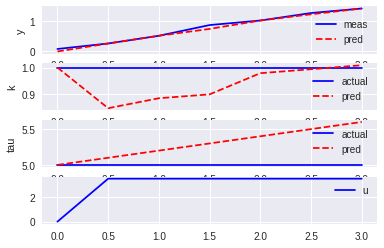

 ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            5
   Intermediates:            1
   Connections  :            0
   Equations    :            3
   Residuals    :            2
 
 Number of state variables:              3
 Number of total equations: -            3
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 solver            3  not supported
 using default solver: APOPT
 ----------------------------------------------
 Dynamic Simulation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  0.00000E+00  9.98271E-02
    1  0.00000E+00  9.98271E-02
 Successful s

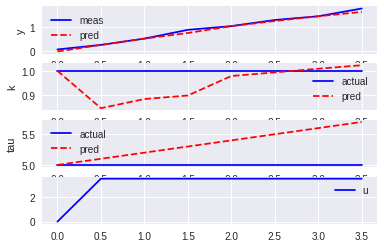

 ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            5
   Intermediates:            1
   Connections  :            0
   Equations    :            3
   Residuals    :            2
 
 Number of state variables:              3
 Number of total equations: -            3
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 solver            3  not supported
 using default solver: APOPT
 ----------------------------------------------
 Dynamic Simulation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  2.22045E-36  9.07519E-02
    1  2.22045E-36  9.07519E-02
 Successful s

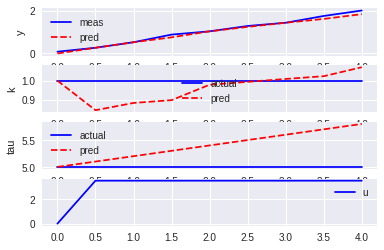

 ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            5
   Intermediates:            1
   Connections  :            0
   Equations    :            3
   Residuals    :            2
 
 Number of state variables:              3
 Number of total equations: -            3
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 solver            3  not supported
 using default solver: APOPT
 ----------------------------------------------
 Dynamic Simulation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  2.22045E-36  8.25017E-02
    1  2.22045E-36  8.25017E-02
 Successful s

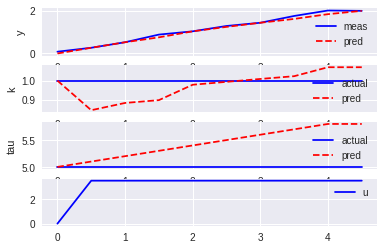

 ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            5
   Intermediates:            1
   Connections  :            0
   Equations    :            3
   Residuals    :            2
 
 Number of state variables:              3
 Number of total equations: -            3
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 solver            3  not supported
 using default solver: APOPT
 ----------------------------------------------
 Dynamic Simulation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  2.22045E-36  7.50016E-02
    1  2.22045E-36  7.50016E-02
 Successful s

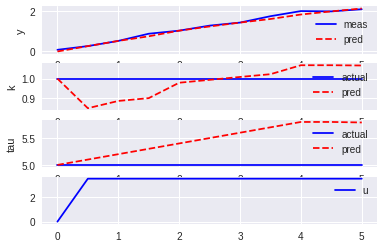

 ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            5
   Intermediates:            1
   Connections  :            0
   Equations    :            3
   Residuals    :            2
 
 Number of state variables:              3
 Number of total equations: -            3
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 solver            3  not supported
 using default solver: APOPT
 ----------------------------------------------
 Dynamic Simulation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  4.44089E-36  6.31434E-01
    1  4.44089E-36  6.31434E-01
 Successful s

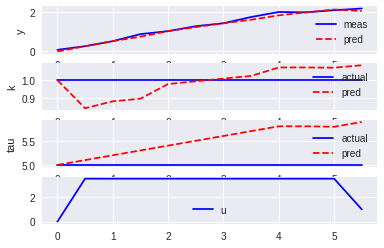

 ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            5
   Intermediates:            1
   Connections  :            0
   Equations    :            3
   Residuals    :            2
 
 Number of state variables:              3
 Number of total equations: -            3
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 solver            3  not supported
 using default solver: APOPT
 ----------------------------------------------
 Dynamic Simulation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  1.11022E-36  5.28215E-02
    1  1.11022E-36  5.28215E-02
 Successful s

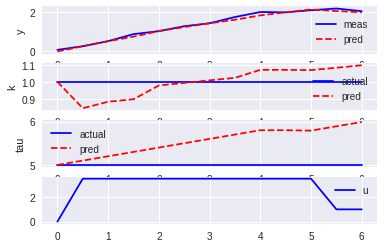

 ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            5
   Intermediates:            1
   Connections  :            0
   Equations    :            3
   Residuals    :            2
 
 Number of state variables:              3
 Number of total equations: -            3
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 solver            3  not supported
 using default solver: APOPT
 ----------------------------------------------
 Dynamic Simulation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  0.00000E+00  4.80195E-02
    1  0.00000E+00  4.80195E-02
 Successful s

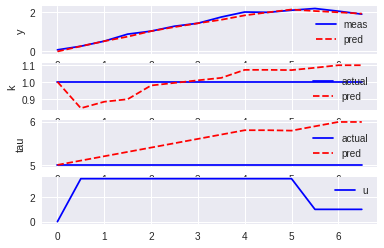

 ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            5
   Intermediates:            1
   Connections  :            0
   Equations    :            3
   Residuals    :            2
 
 Number of state variables:              3
 Number of total equations: -            3
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 solver            3  not supported
 using default solver: APOPT
 ----------------------------------------------
 Dynamic Simulation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  0.00000E+00  4.36541E-02
    1  0.00000E+00  4.36541E-02
 Successful s

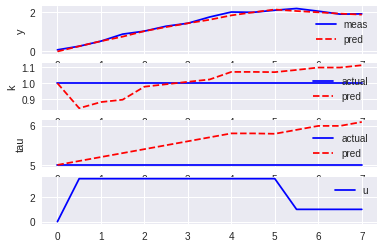

 ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            5
   Intermediates:            1
   Connections  :            0
   Equations    :            3
   Residuals    :            2
 
 Number of state variables:              3
 Number of total equations: -            3
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 solver            3  not supported
 using default solver: APOPT
 ----------------------------------------------
 Dynamic Simulation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  1.11022E-36  3.96856E-02
    1  1.11022E-36  3.96856E-02
 Successful s

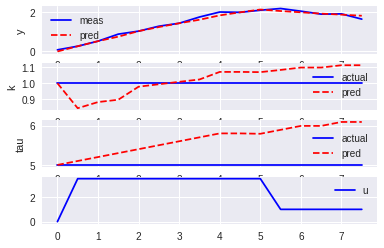

 ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            5
   Intermediates:            1
   Connections  :            0
   Equations    :            3
   Residuals    :            2
 
 Number of state variables:              3
 Number of total equations: -            3
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 solver            3  not supported
 using default solver: APOPT
 ----------------------------------------------
 Dynamic Simulation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  1.11022E-36  3.60778E-02
    1  1.11022E-36  3.60778E-02
 Successful s

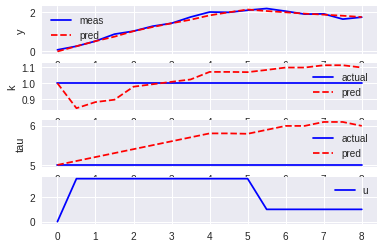

 ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            5
   Intermediates:            1
   Connections  :            0
   Equations    :            3
   Residuals    :            2
 
 Number of state variables:              3
 Number of total equations: -            3
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 solver            3  not supported
 using default solver: APOPT
 ----------------------------------------------
 Dynamic Simulation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  3.33067E-36  3.27980E-02
    1  3.33067E-36  3.27980E-02
 Successful s

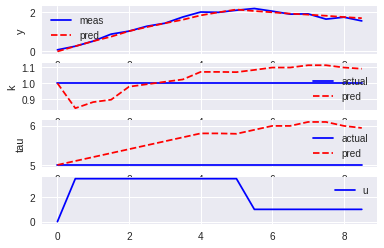

 ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            5
   Intermediates:            1
   Connections  :            0
   Equations    :            3
   Residuals    :            2
 
 Number of state variables:              3
 Number of total equations: -            3
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 solver            3  not supported
 using default solver: APOPT
 ----------------------------------------------
 Dynamic Simulation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  1.11022E-36  2.98164E-02
    1  1.11022E-36  2.98164E-02
 Successful s

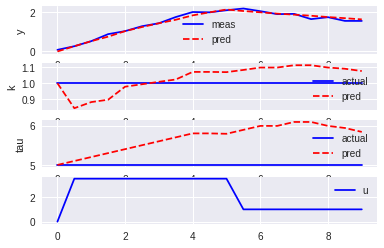

 ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            5
   Intermediates:            1
   Connections  :            0
   Equations    :            3
   Residuals    :            2
 
 Number of state variables:              3
 Number of total equations: -            3
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 solver            3  not supported
 using default solver: APOPT
 ----------------------------------------------
 Dynamic Simulation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  0.00000E+00  2.71058E-02
    1  0.00000E+00  2.71058E-02
 Successful s

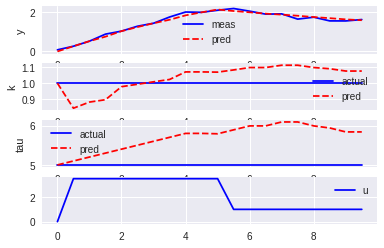

 ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            5
   Intermediates:            1
   Connections  :            0
   Equations    :            3
   Residuals    :            2
 
 Number of state variables:              3
 Number of total equations: -            3
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 solver            3  not supported
 using default solver: APOPT
 ----------------------------------------------
 Dynamic Simulation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  5.55112E-37  2.46416E-02
    1  5.55112E-37  2.46416E-02
 Successful s

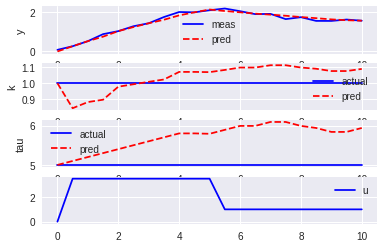

 ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            5
   Intermediates:            1
   Connections  :            0
   Equations    :            3
   Residuals    :            2
 
 Number of state variables:              3
 Number of total equations: -            3
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 solver            3  not supported
 using default solver: APOPT
 ----------------------------------------------
 Dynamic Simulation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  0.00000E+00  1.12472E+00
    1  0.00000E+00  1.12472E+00
 Successful s

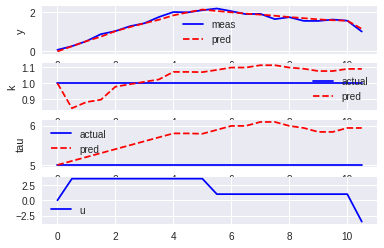

 ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            5
   Intermediates:            1
   Connections  :            0
   Equations    :            3
   Residuals    :            2
 
 Number of state variables:              3
 Number of total equations: -            3
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 solver            3  not supported
 using default solver: APOPT
 ----------------------------------------------
 Dynamic Simulation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  0.00000E+00  4.49718E-01
    1  0.00000E+00  4.49718E-01
 Successful s

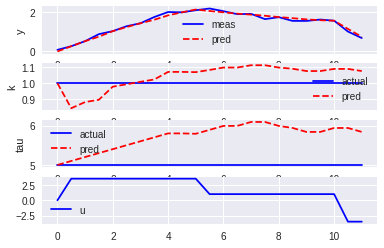

 ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            5
   Intermediates:            1
   Connections  :            0
   Equations    :            3
   Residuals    :            2
 
 Number of state variables:              3
 Number of total equations: -            3
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 solver            3  not supported
 using default solver: APOPT
 ----------------------------------------------
 Dynamic Simulation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  4.44089E-36  4.08835E-01
    1  4.44089E-36  4.08835E-01
 Successful s

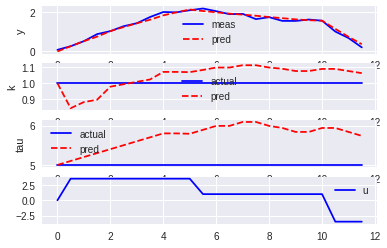

 ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            5
   Intermediates:            1
   Connections  :            0
   Equations    :            3
   Residuals    :            2
 
 Number of state variables:              3
 Number of total equations: -            3
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 solver            3  not supported
 using default solver: APOPT
 ----------------------------------------------
 Dynamic Simulation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  5.55112E-37  3.71668E-01
    1  5.55112E-37  3.71668E-01
 Successful s

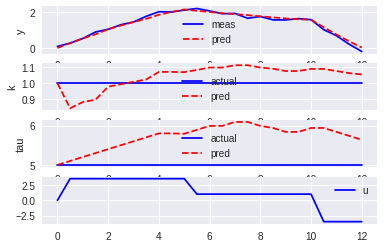

 ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            5
   Intermediates:            1
   Connections  :            0
   Equations    :            3
   Residuals    :            2
 
 Number of state variables:              3
 Number of total equations: -            3
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 solver            3  not supported
 using default solver: APOPT
 ----------------------------------------------
 Dynamic Simulation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  4.44089E-36  3.37880E-01
    1  4.44089E-36  3.37880E-01
 Successful s

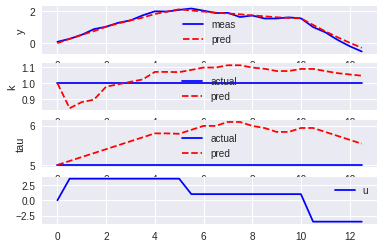

 ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            5
   Intermediates:            1
   Connections  :            0
   Equations    :            3
   Residuals    :            2
 
 Number of state variables:              3
 Number of total equations: -            3
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 solver            3  not supported
 using default solver: APOPT
 ----------------------------------------------
 Dynamic Simulation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  5.55112E-37  3.07164E-01
    1  5.55112E-37  3.07164E-01
 Successful s

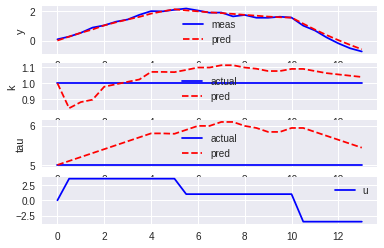

 ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            5
   Intermediates:            1
   Connections  :            0
   Equations    :            3
   Residuals    :            2
 
 Number of state variables:              3
 Number of total equations: -            3
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 solver            3  not supported
 using default solver: APOPT
 ----------------------------------------------
 Dynamic Simulation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  1.11022E-36  2.79240E-01
    1  1.11022E-36  2.79240E-01
 Successful s

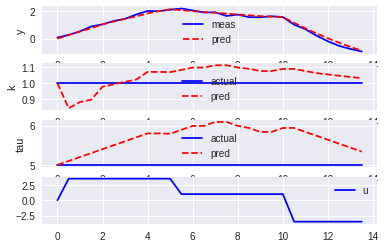

 ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            5
   Intermediates:            1
   Connections  :            0
   Equations    :            3
   Residuals    :            2
 
 Number of state variables:              3
 Number of total equations: -            3
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 solver            3  not supported
 using default solver: APOPT
 ----------------------------------------------
 Dynamic Simulation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  4.44089E-36  2.53854E-01
    1  4.44089E-36  2.53854E-01
 Successful s

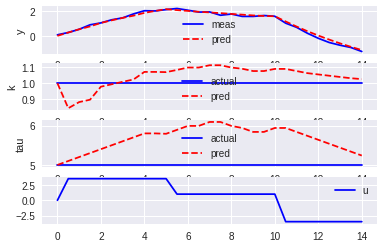

 ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            5
   Intermediates:            1
   Connections  :            0
   Equations    :            3
   Residuals    :            2
 
 Number of state variables:              3
 Number of total equations: -            3
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 solver            3  not supported
 using default solver: APOPT
 ----------------------------------------------
 Dynamic Simulation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  0.00000E+00  2.30777E-01
    1  0.00000E+00  2.30777E-01
 Successful s

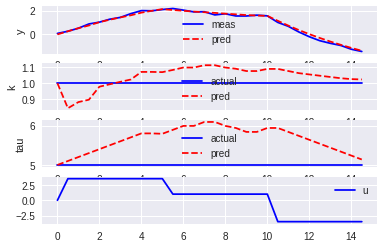

 ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            5
   Intermediates:            1
   Connections  :            0
   Equations    :            3
   Residuals    :            2
 
 Number of state variables:              3
 Number of total equations: -            3
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 solver            3  not supported
 using default solver: APOPT
 ----------------------------------------------
 Dynamic Simulation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  2.22045E-36  2.09797E-01
    1  2.22045E-36  2.09797E-01
 Successful s

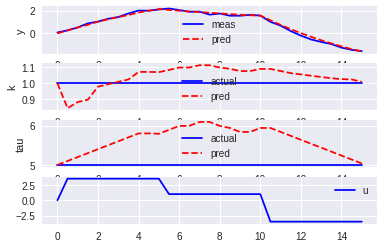

 ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            5
   Intermediates:            1
   Connections  :            0
   Equations    :            3
   Residuals    :            2
 
 Number of state variables:              3
 Number of total equations: -            3
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 solver            3  not supported
 using default solver: APOPT
 ----------------------------------------------
 Dynamic Simulation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  5.55112E-37  5.11890E-01
    1  5.55112E-37  5.11890E-01
 Successful s

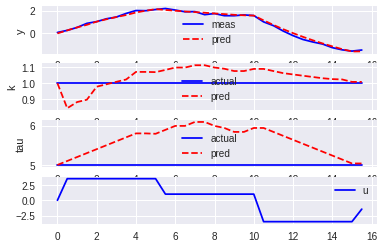

 ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            5
   Intermediates:            1
   Connections  :            0
   Equations    :            3
   Residuals    :            2
 
 Number of state variables:              3
 Number of total equations: -            3
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 solver            3  not supported
 using default solver: APOPT
 ----------------------------------------------
 Dynamic Simulation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  8.32667E-37  6.37796E-03
    1  8.32667E-37  6.37796E-03
 Successful s

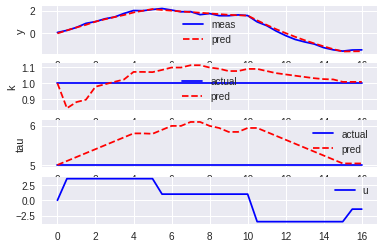

 ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            5
   Intermediates:            1
   Connections  :            0
   Equations    :            3
   Residuals    :            2
 
 Number of state variables:              3
 Number of total equations: -            3
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 solver            3  not supported
 using default solver: APOPT
 ----------------------------------------------
 Dynamic Simulation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  6.93889E-37  5.79815E-03
    1  6.93889E-37  5.79815E-03
 Successful s

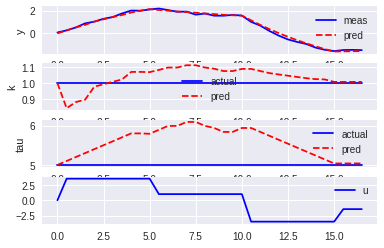

 ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            5
   Intermediates:            1
   Connections  :            0
   Equations    :            3
   Residuals    :            2
 
 Number of state variables:              3
 Number of total equations: -            3
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 solver            3  not supported
 using default solver: APOPT
 ----------------------------------------------
 Dynamic Simulation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  6.93889E-37  5.27104E-03
    1  6.93889E-37  5.27104E-03
 Successful s

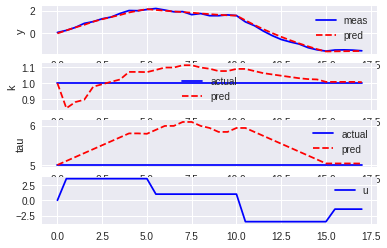

 ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            5
   Intermediates:            1
   Connections  :            0
   Equations    :            3
   Residuals    :            2
 
 Number of state variables:              3
 Number of total equations: -            3
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 solver            3  not supported
 using default solver: APOPT
 ----------------------------------------------
 Dynamic Simulation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  2.77556E-36  4.79186E-03
    1  2.77556E-36  4.79186E-03
 Successful s

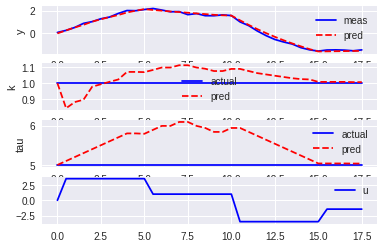

 ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            5
   Intermediates:            1
   Connections  :            0
   Equations    :            3
   Residuals    :            2
 
 Number of state variables:              3
 Number of total equations: -            3
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 solver            3  not supported
 using default solver: APOPT
 ----------------------------------------------
 Dynamic Simulation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  3.05311E-36  4.35623E-03
    1  3.05311E-36  4.35623E-03
 Successful s

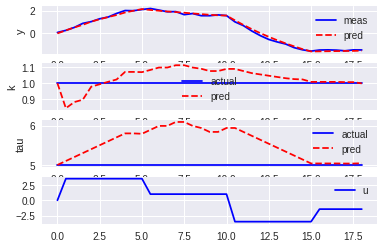

 ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            5
   Intermediates:            1
   Connections  :            0
   Equations    :            3
   Residuals    :            2
 
 Number of state variables:              3
 Number of total equations: -            3
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 solver            3  not supported
 using default solver: APOPT
 ----------------------------------------------
 Dynamic Simulation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  6.93889E-37  3.96021E-03
    1  6.93889E-37  3.96021E-03
 Successful s

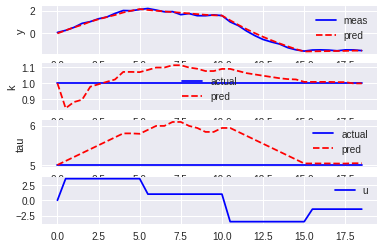

 ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            5
   Intermediates:            1
   Connections  :            0
   Equations    :            3
   Residuals    :            2
 
 Number of state variables:              3
 Number of total equations: -            3
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 solver            3  not supported
 using default solver: APOPT
 ----------------------------------------------
 Dynamic Simulation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  2.77556E-37  3.60019E-03
    1  2.77556E-37  3.60019E-03
 Successful s

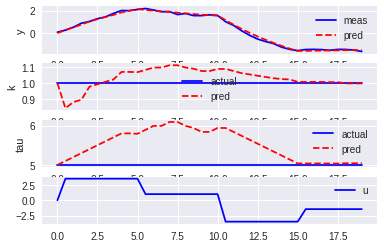

 ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            5
   Intermediates:            1
   Connections  :            0
   Equations    :            3
   Residuals    :            2
 
 Number of state variables:              3
 Number of total equations: -            3
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 solver            3  not supported
 using default solver: APOPT
 ----------------------------------------------
 Dynamic Simulation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  2.91434E-36  3.27290E-03
    1  2.91434E-36  3.27290E-03
 Successful s

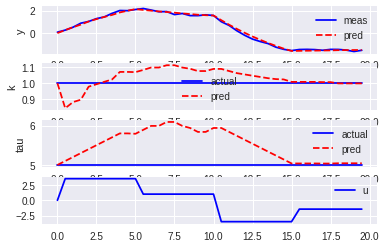

 ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            5
   Intermediates:            1
   Connections  :            0
   Equations    :            3
   Residuals    :            2
 
 Number of state variables:              3
 Number of total equations: -            3
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 solver            3  not supported
 using default solver: APOPT
 ----------------------------------------------
 Dynamic Simulation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  6.24500E-37  2.97537E-03
    1  6.24500E-37  2.97537E-03
 Successful s

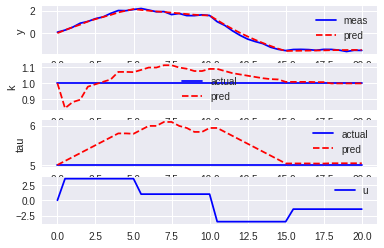

 ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            5
   Intermediates:            1
   Connections  :            0
   Equations    :            3
   Residuals    :            2
 
 Number of state variables:              3
 Number of total equations: -            3
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 solver            3  not supported
 using default solver: APOPT
 ----------------------------------------------
 Dynamic Simulation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  4.44089E-36  9.61320E-01
    1  4.44089E-36  9.61320E-01
 Successful s

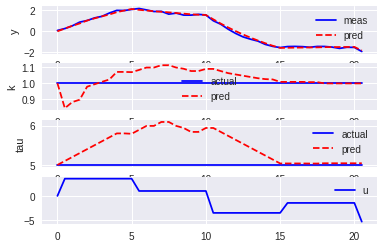

 ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            5
   Intermediates:            1
   Connections  :            0
   Equations    :            3
   Residuals    :            2
 
 Number of state variables:              3
 Number of total equations: -            3
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 solver            3  not supported
 using default solver: APOPT
 ----------------------------------------------
 Dynamic Simulation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  0.00000E+00  1.72327E-01
    1  0.00000E+00  1.72327E-01
 Successful s

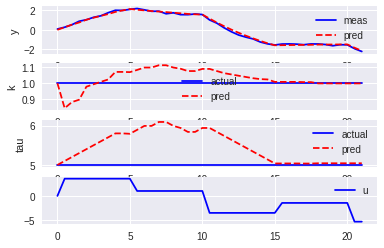

 ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            5
   Intermediates:            1
   Connections  :            0
   Equations    :            3
   Residuals    :            2
 
 Number of state variables:              3
 Number of total equations: -            3
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 solver            3  not supported
 using default solver: APOPT
 ----------------------------------------------
 Dynamic Simulation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  4.44089E-36  1.56660E-01
    1  4.44089E-36  1.56660E-01
 Successful s

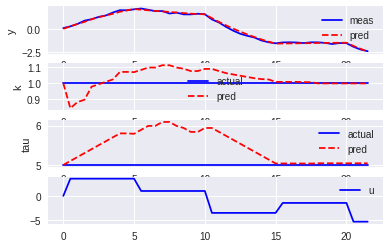

 ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            5
   Intermediates:            1
   Connections  :            0
   Equations    :            3
   Residuals    :            2
 
 Number of state variables:              3
 Number of total equations: -            3
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 solver            3  not supported
 using default solver: APOPT
 ----------------------------------------------
 Dynamic Simulation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  4.44089E-36  1.42419E-01
    1  4.44089E-36  1.42419E-01
 Successful s

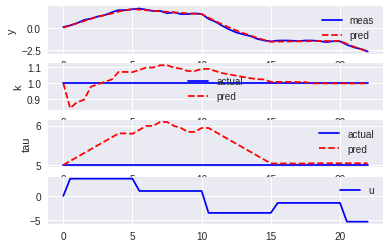

 ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            5
   Intermediates:            1
   Connections  :            0
   Equations    :            3
   Residuals    :            2
 
 Number of state variables:              3
 Number of total equations: -            3
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 solver            3  not supported
 using default solver: APOPT
 ----------------------------------------------
 Dynamic Simulation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  8.88178E-36  1.29471E-01
    1  8.88178E-36  1.29471E-01
 Successful s

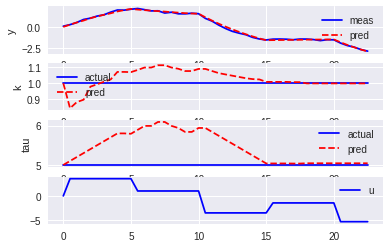

 ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            5
   Intermediates:            1
   Connections  :            0
   Equations    :            3
   Residuals    :            2
 
 Number of state variables:              3
 Number of total equations: -            3
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 solver            3  not supported
 using default solver: APOPT
 ----------------------------------------------
 Dynamic Simulation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  0.00000E+00  5.88507E-02
    1  0.00000E+00  5.88507E-02
 Successful s

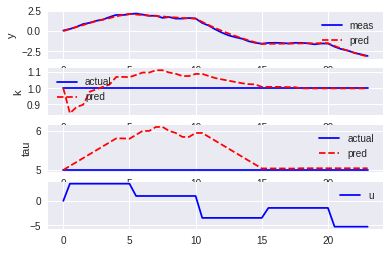

 ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            5
   Intermediates:            1
   Connections  :            0
   Equations    :            3
   Residuals    :            2
 
 Number of state variables:              3
 Number of total equations: -            3
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 solver            3  not supported
 using default solver: APOPT
 ----------------------------------------------
 Dynamic Simulation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  4.44089E-36  5.35006E-02
    1  4.44089E-36  5.35006E-02
 Successful s

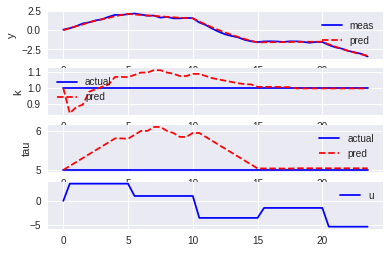

 ----------------------------------------------------------------
 APMonitor, Version 0.8.7
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            5
   Intermediates:            1
   Connections  :            0
   Equations    :            3
   Residuals    :            2
 
 Number of state variables:              3
 Number of total equations: -            3
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 solver            3  not supported
 using default solver: APOPT
 ----------------------------------------------
 Dynamic Simulation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  6.66134E-36  4.86369E-02
    1  6.66134E-36  4.86369E-02
 Successful s

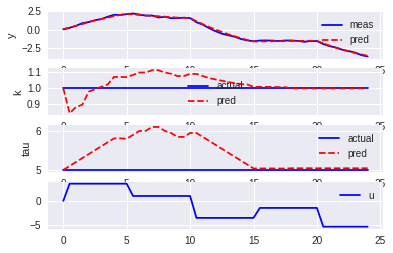

In [6]:
#@markdown Solution using GEKKO

# run once to install gekko
try:
    from pip import main as pipmain
except:
    from pip._internal import main as pipmain
pipmain(['install','gekko'])

import numpy as np
from random import random
from gekko import GEKKO
import matplotlib.pyplot as plt

n = 1 # process model order

#%% Process
# Change to True for MacOS
rmt = False 
p = GEKKO(remote=rmt)
p.time = [0,.5]

#Parameters
p.u = p.MV(value=0)
p.K = p.Param(value=1) #gain
p.tau = p.Param(value=5) #time constant

#Intermediate
p.x = [p.Intermediate(p.u)]

#Variables
p.x.extend([p.Var() for _ in range(n)])  #state variables
p.y = p.SV() #measurement

#Equations
p.Equations([p.tau/n * p.x[i+1].dt() == -p.x[i+1] + p.x[i] for i in range(n)])
p.Equation(p.y == p.K * p.x[n])

#options
p.options.IMODE = 4

#%% Model
m = GEKKO(remote=rmt)
#0-20 by 0.5 -- discretization must match simulation
m.time = np.linspace(0,20,41)

#Parameters
m.u = m.MV() #input
m.K = m.FV(value=1, lb=0.3, ub=3) #gain
m.tau = m.FV(value=5, lb=1, ub=10) #time constant

#Variables
m.x = m.SV() #state variable
m.y = m.CV() #measurement

#Equations
m.Equations([m.tau * m.x.dt() == -m.x + m.u, 
             m.y == m.K * m.x])

#Options
m.options.IMODE = 5 #MHE
m.options.EV_TYPE = 1

# STATUS = 0, optimizer doesn't adjust value
# STATUS = 1, optimizer can adjust
m.u.STATUS = 0
m.K.STATUS = 1
m.tau.STATUS = 1

# FSTATUS = 0, no measurement
# FSTATUS = 1, measurement used to update model
m.u.FSTATUS = 1
m.K.FSTATUS = 0
m.tau.FSTATUS = 0
m.y.FSTATUS = 1

# DMAX = maximum movement each cycle
m.K.DMAX = 1
m.tau.DMAX = .1

# MEAS_GAP = dead-band for measurement / model mismatch
m.y.MEAS_GAP = 0.0

#%% problem configuration
# number of cycles
cycles = 50
# time vector
tm = np.linspace(0,25,51)
# noise level
noise = 0.25

# values of u change randomly over time every 10th step
u_meas = np.zeros(cycles)
step_u = 0
for i in range(0,cycles):
    if ((i-1)%10) == 0:
        # random step (-5 to 5)
        step_u = step_u + (random()-0.5)*10
    u_meas[i] = step_u

#%% run process and estimator for cycles
y_meas = np.zeros(cycles)
y_est = np.zeros(cycles)
k_est = np.zeros(cycles)*np.nan
tau_est = np.zeros(cycles)*np.nan
for i in range(cycles-1):
    # process simulator
    p.u.MEAS = u_meas[i]
    p.solve()
    r = (random()-0.5)*noise
    y_meas[i] = p.y.value[1] + r # add noise

    # estimator
    m.u.MEAS = u_meas[i]
    m.y.MEAS = y_meas[i]
    m.solve()
    y_est[i] = m.y.MODEL 
    k_est[i] = m.K.NEWVAL 
    tau_est[i] = m.tau.NEWVAL 

    plt.clf()
    plt.subplot(4,1,1)
    plt.plot(tm[0:i+1],y_meas[0:i+1],'b-')
    plt.plot(tm[0:i+1],y_est[0:i+1],'r--')
    plt.legend(('meas','pred'))
    plt.ylabel('y')
    plt.subplot(4,1,2)
    plt.plot(tm[0:i+1],np.ones(i+1)*p.K.value[0],'b-')
    plt.plot(tm[0:i+1],k_est[0:i+1],'r--')
    plt.legend(('actual','pred'))
    plt.ylabel('k')
    plt.subplot(4,1,3)
    plt.plot(tm[0:i+1],np.ones(i+1)*p.tau.value[0],'b-')
    plt.plot(tm[0:i+1],tau_est[0:i+1],'r--')
    plt.legend(('actual','pred'))
    plt.ylabel('tau')
    plt.subplot(4,1,4)
    plt.plot(tm[0:i+1],u_meas[0:i+1],'b-')
    plt.legend('u')
    plt.draw()
    plt.pause(0.05)